## Практическое задание к уроку 14 по теме "Transfer learning".

*Взять данные из https://www.kaggle.com/datasets/mrapplexz/bashim-quotes  
обучить модель GPT для генерации своих цитат*

В данной задаче обучу с нуля модель GPT-2 и токенизатор для неё,  
а потом посмотрим, как она будет генерировать цитаты. Хоть тема  
урока, вроде бы, и предусматривает использование предобученной  
модели и дальнейшее её дообучение, но так мы часто делаем, и в  
этот раз хотелось бы всё сделать с нуля. В качестве transfer learning  
возьмём только архитектуру GPT-2.

Загрузим библиотеки и датасет:

In [1]:
%matplotlib inline

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from time import time
from tokenizers import Tokenizer
from tokenizers.decoders import WordPiece
from tokenizers.models import BPE
from tokenizers.normalizers import StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
import torch
from torch import nn
from torchinfo import summary
from transformers import GPT2Config, GPT2LMHeadModel
from tqdm import tqdm

In [2]:
RANDOM_STATE = 29

In [3]:
dataset = load_dataset('json', data_files='./dataset.jsonl', split='train')

Using custom data configuration default-93d1eaaef032e4bd
Found cached dataset json (/home/shkin/.cache/huggingface/datasets/json/default-93d1eaaef032e4bd/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


In [4]:
dataset

Dataset({
    features: ['id', 'date', 'rating', 'text'],
    num_rows: 81497
})

In [5]:
pd.DataFrame(dataset[:5])

,id,date,rating,text
0,1,2004-08-30 11:24:00,22010,"<Ares> ppdv, все юниксы очень дружелюбны.. они..."
1,2,2004-08-30 11:25:00,25105,<томатик_рад> а ты не чувствуешь красоту мира?...
2,3,2004-08-30 11:27:00,7192,"<Дор> ""мышка, почему у тебя такие большие глаз..."
3,4,2004-08-30 11:28:00,29169,"<PPDV[os2]> ""Мальчики, вы что больные, бегать ..."
4,5,2004-08-30 11:26:00,7140,<Ohtori_Akio> мы - как разработчики - живём с ...


In [6]:
train = dataset['text']

In [7]:
train[:10]

['<Ares> ppdv, все юниксы очень дружелюбны.. они просто очень разборчивы в друзьях ;)',
 '<томатик_рад> а ты не чувствуешь красоту мира?\n<fox> честно говоря, я сейчас чувствую только отсутствие http.\n<томатик_рад> не туда смотришь, глянь вокруг!\n<fox> как я гляну, если http не работает? :/',
 '<Дор> "мышка, почему у тебя такие большие глаза?" УЙДИ!!! я ХАРАКИРИ делаю!!!!!!',
 '<PPDV[os2]> "Мальчики, вы что больные, бегать в палату к девочкам?! - Если б мы были больные - мы б бегали к другим мальчикам"',
 '<Ohtori_Akio> мы - как разработчики - живём с субейзом под одбц. \n<Ohtori_Akio> лучше бы мы жили в пещере с гоблинами.',
 '<Ohtori_Akio> о чём ни спроси - все обычно советуют сменить операционку, потом железо, потом страну пребывания, ориентацию, всё, что угодно... вместо того, чтобы подсказать нужную настройку в софтине.',
 '<Hellcat> Настояший программер пьёт один раз в день - с утра и до вечера',
 '<Kosh_подстригся> мой критерий в аниме - много крови и много теток с эээ... тетк

Напишем функцию предобработки. В ней буду заменять ники  
пользователей в угловых скобках на числа для обобщения.  
Также добавлю специальные токены. Несмотря на то, что  
можно задать правило для пост-обработчика (post_processor)  
токенайзера и автоматизировать этот процесс, настройка  
недостаточно гибкая, так как я хотел бы разделять цитаты  
каждого пользователя спецтокеном \[SEP\] и при этом подавать  
всю цитату целиком. В пост-обработчике нельзя разделить  
текст на части, а подавать текст парами тоже не вариант,  
так как иногда количество реплик в цитате более двух.  
  
UPD: Здесь использую токен \[CLS\], хотя такое обозначение  
более характерно для Берта и cls-пулинга. Более правильно  
было бы использовать \[BOS\] или \<\s\>, но так как мы обучаем  
с нуля, это не имеет значения.

In [8]:
def preprocess(text):
    text = '[CLS] ' + text + ' [EOS]'
    text = re.sub('\n', ' [SEP]\n', text)
    users = re.findall('<.+?>', text)
    
    if len(users) > 1:
        for user in users:
            text = text.replace(user, str(users.index(user)) + ':')
    
    # Если пользователь один, то убираем его ник
    elif users:
        text = text.replace(users[0], '')

    return text

Посмотрим, как будет выглядеть результат предобработки:

In [9]:
print(preprocess(train[1]))

[CLS] 0: а ты не чувствуешь красоту мира? [SEP]
1: честно говоря, я сейчас чувствую только отсутствие http. [SEP]
0: не туда смотришь, глянь вокруг! [SEP]
1: как я гляну, если http не работает? :/ [EOS]


Инициализируем токенайзер, за его основу возьмём алгоритм BPE,  
он используется и в предобученной GPT-2:

In [10]:
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))

Зададим нормализатор токенайзера, который будет сразу убирать  
ударения слов:

In [11]:
normalizer = StripAccents()
tokenizer.normalizer = normalizer

Зададим претокенайзер, который будет разделять текст на  
токены по пробелам, а также выделять пунктуацию в отдельные  
токены. Здесь имеем отличие от предобученной GPT-2, в которой  
используется ByteLevel.

In [12]:
pretokenizer = Whitespace()
tokenizer.pre_tokenizer = pretokenizer

Зададим размер словаря:

In [13]:
VOCAB_SIZE = 10000

Зададим трейнер, который будет обучать токенайзер:

In [14]:
trainer = BpeTrainer(vocab_size=VOCAB_SIZE,
                     special_tokens=['[UNK]', '[CLS]', '[SEP]', '[PAD]', '[EOS]'],
                     continuing_subword_prefix='##',
                     show_progress=True)

Обработаем тексты и посмотрим на них:

In [15]:
train_processed = [preprocess(text) for text in train]

In [16]:
train_processed[:5]

['[CLS]  ppdv, все юниксы очень дружелюбны.. они просто очень разборчивы в друзьях ;) [EOS]',
 '[CLS] 0: а ты не чувствуешь красоту мира? [SEP]\n1: честно говоря, я сейчас чувствую только отсутствие http. [SEP]\n0: не туда смотришь, глянь вокруг! [SEP]\n1: как я гляну, если http не работает? :/ [EOS]',
 '[CLS]  "мышка, почему у тебя такие большие глаза?" УЙДИ!!! я ХАРАКИРИ делаю!!!!!! [EOS]',
 '[CLS]  "Мальчики, вы что больные, бегать в палату к девочкам?! - Если б мы были больные - мы б бегали к другим мальчикам" [EOS]',
 '[CLS] 0: мы - как разработчики - живём с субейзом под одбц.  [SEP]\n0: лучше бы мы жили в пещере с гоблинами. [EOS]']

Обучим токенайзер на этих текстах:

In [17]:
tokenizer.train_from_iterator(train_processed, trainer=trainer)

Убедимся, что в текстах хватило токенов для нашего словаря:

In [18]:
len(tokenizer.get_vocab())

10000

In [19]:
tokenizer.get_vocab_size()

10000

Для расшифровки сгенерированных текстов зададим декодер.  
Он также отличен от декодера ByteLevel, используемого в  
предобученной GPT-2.

In [20]:
tokenizer.decoder = WordPiece()

Посмотрим, как токенизатор кодирует и декодирует:

In [21]:
print(tokenizer.encode(train_processed[4]).tokens)

['[CLS]', '0', ':', 'мы', '-', 'как', 'разработ', '##чики', '-', 'жив', '##ём', 'с', 'суб', '##ей', '##зом', 'под', 'од', '##б', '##ц', '.', '[SEP]', '0', ':', 'лучше', 'бы', 'мы', 'жили', 'в', 'пе', '##щ', '##ере', 'с', 'го', '##бли', '##нами', '.', '[EOS]']


In [22]:
print(tokenizer.encode(train_processed[4]).ids)

[1, 21, 31, 1047, 18, 880, 2876, 3194, 18, 2921, 1487, 256, 3729, 887, 4506, 932, 1037, 494, 530, 19, 2, 21, 31, 1641, 876, 1047, 7488, 241, 1511, 506, 883, 256, 886, 1793, 2496, 19, 4]


In [23]:
tokenizer.decode(tokenizer.encode(train_processed[4]).ids)

'0 : мы - как разработчики - живём с субейзом под одбц. 0 : лучше бы мы жили в пещере с гоблинами.'

Для принятия решения о длине текстов построим гистограмму длин токенов:

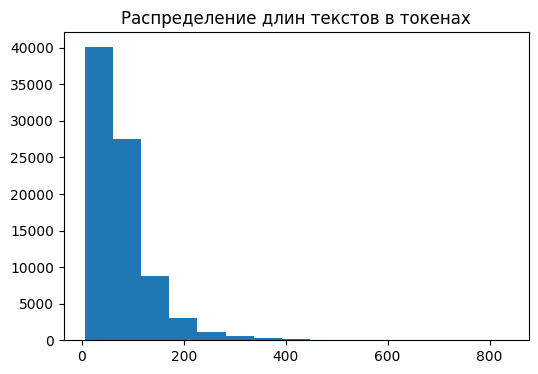

In [24]:
plt.figure(figsize=(6, 4))

plt.hist([len(tokenized.ids) for tokenized in tokenizer.encode_batch(train_processed)], bins=15)
plt.title('Распределение длин текстов в токенах')
plt.show()

Будем использовать длину текстов в 512 токенов. Предобученная  
GPT-2 использует 1024 токена.

In [25]:
MAX_LEN = 512

Зададим режим паддинга и truncation для токенайзера:

In [26]:
tokenizer.token_to_id('[PAD]')

3

In [27]:
tokenizer.enable_padding(pad_id=3, length=MAX_LEN)

In [28]:
tokenizer.enable_truncation(max_length=MAX_LEN)

Зададим конфиг для модели GPT-2. В дефолтном конфиге  
поменяем значение длины текстов и размер словаря. Также  
укажем айдишники специальных токенов.

In [29]:
tokenizer.token_to_id('[CLS]')

1

In [30]:
tokenizer.token_to_id('[EOS]')

4

In [31]:
config = GPT2Config(vocab_size=VOCAB_SIZE, 
                    bos_token_id=1, 
                    eos_token_id=4,
                    n_positions=MAX_LEN)
config

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 4,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 512,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.24.0",
  "use_cache": true,
  "vocab_size": 10000
}

Данный конфиг соответствует модели GPT-2 SMALL с 12 слоями  
и размером эмбеддингов 768. Мы поменяли под нашу задачу только  
длину текстов и размер словаря.

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Напишем класс датасета. В нём будем делать токенизацию и формирование  
словаря для передачи модели. В качестве таргетов будут токены, следующие  
за текущим:

In [33]:
class BashDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.encodings = tokenizer.encode_batch(data)

    def __getitem__(self, index):
        encoding = self.encodings[index]
            
        dictionary = {'input_ids': torch.IntTensor(encoding.ids).to(device),
                      'attention_mask': torch.IntTensor(encoding.attention_mask).to(device),
                      'token_type_ids': torch.IntTensor(encoding.type_ids).to(device)
                     }
        
        inputs = {k: v[:-1] for k, v in dictionary.items()}
        labels = dictionary['input_ids'][1:]
        
        return inputs, labels.long()
    
    def __len__(self):
        return len(self.encodings)

Создадим даталоадер. Размер батча мал, но бОльшие значения  
приводят к ошибке нехватки памяти при обучении.

In [34]:
dataset = BashDataset(train_processed)

In [35]:
BATCH_SIZE = 4

In [36]:
torch.random.manual_seed(RANDOM_STATE)

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

Посмотрим на модель:

In [37]:
summary(GPT2LMHeadModel(config))

Layer (type:depth-idx)                             Param #
GPT2LMHeadModel                                    --
├─GPT2Model: 1-1                                   --
│    └─Embedding: 2-1                              7,680,000
│    └─Embedding: 2-2                              393,216
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─GPT2Block: 3-1                         7,087,872
│    │    └─GPT2Block: 3-2                         7,087,872
│    │    └─GPT2Block: 3-3                         7,087,872
│    │    └─GPT2Block: 3-4                         7,087,872
│    │    └─GPT2Block: 3-5                         7,087,872
│    │    └─GPT2Block: 3-6                         7,087,872
│    │    └─GPT2Block: 3-7                         7,087,872
│    │    └─GPT2Block: 3-8                         7,087,872
│    │    └─GPT2Block: 3-9                         7,087,872
│    │    └─GPT2Block: 3-10                        7,087

Итого нам нужно с нуля обучить 93 млн. параметров.

Напишем функцию для более красивого вывода времени,  
затраченного на обучение:

In [38]:
def calc_time(start, end):
    diff = end - start
    mins = diff // 60
    secs = diff % 60
    return f'{int(mins)} min {int(secs)} s'

Напишем функцию обучения. В рамках функции есть возможность  
дообучать модель, а также происходит сохранение модели в конце  
каждой эпохи.  
  
UPD: Ещё реализован механизм поиска оптимального learning rate  
с использованием scheduler, где мы линейно повышаем lr каждые 100  
батчей и фиксируем текущий лосс, чтобы потом всё это отразить на  
графике.

In [39]:
def train_nn(epochs=5, lr=5e-5, searching_lr=False, warm_start=False, model=None):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
    if not warm_start:
        net = GPT2LMHeadModel(config).to(device)
    
    else:
        assert model is not None, 'Нужно передать модель в функцию, т.к. warm_start=True'
        net = model.to(device)
            
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if searching_lr:
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.0001, total_iters=len(loader) // 100)
        losses_history = []
        lr_history = []
        counter = 0
        end = scheduler.total_iters * 100
    
    for epoch in range(epochs):
        start_time = time()
        losses = 0.
        
        for inputs, labels in tqdm(loader):
            net.train()

            optimizer.zero_grad()
            outputs = net(**inputs)[0].permute(0, 2, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses += loss.item()

            if searching_lr:
                counter += 1
                
                if counter % 100 == 0:
                    losses_history.append(loss.item())
                    lr_history.extend(scheduler.get_last_lr())
                    scheduler.step()
                    
                if counter >= end:
                    return losses_history, lr_history
        
        net.save_pretrained('./model/')
        
        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Loss: {losses / len(loader):.3f}. ' \
              f'Time: {calc_time(start_time, time())}.')

    print('Training is finished!')
    return net

Обучим почти одну эпоху целиком, чтобы найти оптимальный lr:

In [40]:
losses, lrs = train_nn(epochs=1, lr=1e-2, searching_lr=True)

100%|██████████████████████████████████▊| 20299/20375 [1:31:19<00:20,  3.70it/s]


Построим график:

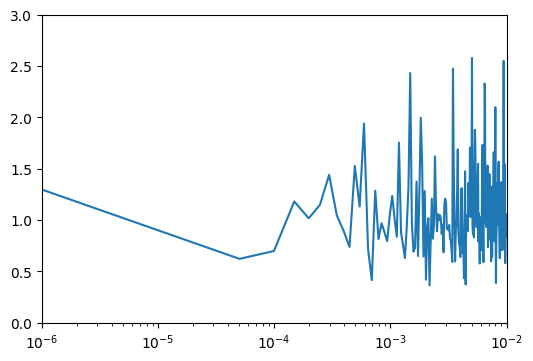

In [43]:
plt.figure(figsize=(6, 4))
plt.semilogx(lrs, losses)
plt.axis([1e-6, 1e-2, 0, 3])
plt.show()

Судя по графику, возьмём значение lr, равное 0,00003.  
При таком значении лосс ещё стабильно убывает и не "перепрыгивает"  
минимумы.

Обучим модель:

In [40]:
model = train_nn(epochs=10, lr=3e-5)

100%|███████████████████████████████████| 20375/20375 [1:33:39<00:00,  3.63it/s]


Epoch [1/10]. Loss: 0.908. Time: 93 min 40 s.


100%|███████████████████████████████████| 20375/20375 [1:41:53<00:00,  3.33it/s]


Epoch [2/10]. Loss: 0.771. Time: 101 min 54 s.


100%|███████████████████████████████████| 20375/20375 [1:31:30<00:00,  3.71it/s]


Epoch [3/10]. Loss: 0.710. Time: 91 min 31 s.


100%|███████████████████████████████████| 20375/20375 [1:31:25<00:00,  3.71it/s]


Epoch [4/10]. Loss: 0.669. Time: 91 min 27 s.


100%|███████████████████████████████████| 20375/20375 [1:31:32<00:00,  3.71it/s]


Epoch [5/10]. Loss: 0.636. Time: 91 min 33 s.


100%|███████████████████████████████████| 20375/20375 [1:31:41<00:00,  3.70it/s]


Epoch [6/10]. Loss: 0.609. Time: 91 min 42 s.


100%|███████████████████████████████████| 20375/20375 [1:31:22<00:00,  3.72it/s]


Epoch [7/10]. Loss: 0.585. Time: 91 min 23 s.


100%|███████████████████████████████████| 20375/20375 [1:32:09<00:00,  3.68it/s]


Epoch [8/10]. Loss: 0.562. Time: 92 min 11 s.


100%|███████████████████████████████████| 20375/20375 [1:32:13<00:00,  3.68it/s]


Epoch [9/10]. Loss: 0.540. Time: 92 min 14 s.


100%|███████████████████████████████████| 20375/20375 [1:32:25<00:00,  3.67it/s]


Epoch [10/10]. Loss: 0.518. Time: 92 min 27 s.
Training is finished!


Лосс ещё слишком велик, и генерация оставляет желать лучшего,  
поэтому дообучим модель ещё на 5 эпох:

In [42]:
model = train_nn(epochs=5, lr=3e-5, warm_start=True, model=model)

100%|███████████████████████████████████| 20375/20375 [1:33:20<00:00,  3.64it/s]


Epoch [1/5]. Loss: 0.528. Time: 93 min 22 s.


100%|███████████████████████████████████| 20375/20375 [1:37:55<00:00,  3.47it/s]


Epoch [2/5]. Loss: 0.491. Time: 97 min 57 s.


100%|███████████████████████████████████| 20375/20375 [1:34:41<00:00,  3.59it/s]


Epoch [3/5]. Loss: 0.468. Time: 94 min 42 s.


100%|███████████████████████████████████| 20375/20375 [1:34:24<00:00,  3.60it/s]


Epoch [4/5]. Loss: 0.447. Time: 94 min 26 s.


100%|███████████████████████████████████| 20375/20375 [1:39:28<00:00,  3.41it/s]


Epoch [5/5]. Loss: 0.428. Time: 99 min 29 s.
Training is finished!


Интересный момент в том, что лосс после предыдущей серии эпох  
сначала показал рост. Это связано с тем, что оптимизатор Adam  
подстраивает скорость обучения индивидуально для каждого параметра,  
в зависимости от величины градиента. При этом lr некоторых параметров  
(возможно, всех) внутри уже был перестроен на более низкие значения.  
А мы снова обучили с прежним lr.  
  
Дообучим ещё, теперь сразу понизим скорость обучения в 3 раза:

In [59]:
model = train_nn(epochs=5, lr=1e-5, warm_start=True, model=model)

100%|███████████████████████████████████| 20375/20375 [1:34:48<00:00,  3.58it/s]


Epoch [1/5]. Loss: 0.345. Time: 94 min 50 s.


100%|███████████████████████████████████| 20375/20375 [1:31:39<00:00,  3.70it/s]


Epoch [2/5]. Loss: 0.317. Time: 91 min 41 s.


100%|███████████████████████████████████| 20375/20375 [1:31:37<00:00,  3.71it/s]


Epoch [3/5]. Loss: 0.296. Time: 91 min 39 s.


100%|███████████████████████████████████| 20375/20375 [1:31:37<00:00,  3.71it/s]


Epoch [4/5]. Loss: 0.276. Time: 91 min 38 s.


100%|███████████████████████████████████| 20375/20375 [1:31:41<00:00,  3.70it/s]


Epoch [5/5]. Loss: 0.256. Time: 91 min 42 s.
Training is finished!


Такое резкое снижение лосса с предыдущей серии эпох, возможно,  
связано с тем, что мы опять взяли слишком большой lr. Но, в отличие  
от прошлого раза, мы не "перепрыгнули" минимум, а сделали бОльший  
шаг в его направлении. Будем считать, что нам повезло.  
Тем не менее, видно, что Adam постепенно привёл значение скорости  
обучения в комфортную для себя норму.  
  
Данный результат всё равно пока ещё приводит к очень некачественной  
генерации текста, поэтому сделаем ещё одну серию эпох. Сократим  
скорость обучения ещё в 2 раза:

In [61]:
model = train_nn(epochs=5, lr=5e-6, warm_start=True, model=model)

100%|███████████████████████████████████| 20375/20375 [1:31:17<00:00,  3.72it/s]


Epoch [1/5]. Loss: 0.250. Time: 91 min 18 s.


100%|███████████████████████████████████| 20375/20375 [1:32:56<00:00,  3.65it/s]


Epoch [2/5]. Loss: 0.231. Time: 92 min 58 s.


100%|███████████████████████████████████| 20375/20375 [1:32:56<00:00,  3.65it/s]


Epoch [3/5]. Loss: 0.216. Time: 92 min 57 s.


100%|███████████████████████████████████| 20375/20375 [1:32:53<00:00,  3.66it/s]


Epoch [4/5]. Loss: 0.200. Time: 92 min 55 s.


100%|███████████████████████████████████| 20375/20375 [1:36:14<00:00,  3.53it/s]


Epoch [5/5]. Loss: 0.184. Time: 96 min 15 s.
Training is finished!


Напишем функцию для генерации цитат:

In [65]:
def generate_text():
    model.eval()
    text = model.generate(
           pad_token_id=3,
           bos_token_id=1,
           eos_token_id=4,
           max_new_tokens=511,
           do_sample=True,
           temperature=1.4,
           num_beams=10,
           top_k=20,
           repetition_penalty=7.,
           length_penalty=-0.4
           )
    
    text = tokenizer.decode(text[0].tolist())
    
    # Обработаем тексовую выдачу. Добавим символы переноса строки,  
    # где они должны быть
    text = re.sub(r'\s([xyzух]{3})', r'\n\1', text)
    text = re.sub(r'\s([012]\s)', r'\n\1', text)
    print(text, end='\n\n')
    print('*' * 100, end='\n\n')

Посмотрим на результаты работы модели:

In [67]:
for _ in range(10):
    generate_text()
print('Генерация закончена!!!!!!!!!!')

xxx : а у вас тоже есть знакомые которые по - разному методу?
yyy : да. например, программисты. высылают перенослить капсу в виде слова " на всякий случай ", " на всякий случай ", " и потом ", " на самом деле ", " перуитивно ".

****************************************************************************************************

xxx : у нас в городе есть традиция.
xxx : которая по - прежнему спрашивает коммунальщика, как нам избавиться от современных проблем с животными, пока они не смогли совершить затворённые выражения " оценок ".

****************************************************************************************************

xxx : А почему ты не помнишь, как это дела?
yyy : Я в детстве любил много всякого мерить, что последовательного перевода я уже вполне себе предпочитаю мультимиллионное знание " Зеленый Вилтон - Фищ ".

****************************************************************************************************

xxx : А у нас в городе есть магазин " Пойматьваемое то

<ins>Вывод:</ins>  
Инициализировали своим конфигом и обучили модель GPT-2 с токенизатором.  
Обучение одной эпохи занимало примерно полтора часа, поэтому пришлось  
ограничить количество эпох, и результат генерации получился не очень  
впечатляющим. Тем не менее, общие принципы обучающих текстов модель уловила.  
Также на качестве генерирования мог сказаться относительно небольшой размер  
словаря, но заранее выбрать оптимальный размер не так просто, а проводить  
обучение заново - очень трудоёмко.  
  
Встретившиеся ситуации с выбором оптимального коэффициента обучения  
привели меня к нескольким мыслям:  
<ul>
  
<li>Лучше обучать модель за один подход, чтобы не вмешиваться в работу<br>
оптимизатора, который сам настраивает значение lr. Но это трудноосуществимо,<br>
ввиду того, что мы не знаем изначально, сколько эпох нам понадобится, а<br>
переобучать потом заново - это "выкинуть на ветер" уже затраченное время<br>
и ресурсы.</li>
<br> 
<li>Если всё-таки нужно дообучить модель, то лучше снова проводить процедуру<br>
поиска оптимального lr, как мы это делали перед началом обучения. Так мы,<br>
конечно, потратим ресурсы, но при правильно подобранном коэффициенте<br>
скорости обучения окажемся, в итоге, в плюсе и по затраченному времени,<br> 
и по качеству обучения.</li>
<br> 
<li>А может быть, вместе с моделью возвращать оптимизатор? Тогда при дообучении<br>
мы будем передавать его вместе с моделью в функцию. Тогда, по идее, для процесса<br>
обучения не будет разницы, обучаем мы за один проход или несколько раз дообучаем.<br>
Обязательно попробую такой подход в следующий раз.</li>
</ul>
  
По итогу задания, отлично попрактиковались в полном цикле обучения модели  
GPT-2 и перечитали много соответствующей документации.